In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import bayespy as bp
import numpy

## Simple Example from [bayespy.org]()

Iteration 1: loglike=-5.491931e+01 (0.002 seconds)
Iteration 2: loglike=-5.343801e+01 (0.002 seconds)
Iteration 3: loglike=-5.343569e+01 (0.002 seconds)
Iteration 4: loglike=-5.343567e+01 (0.002 seconds)
Converged at iteration 4.


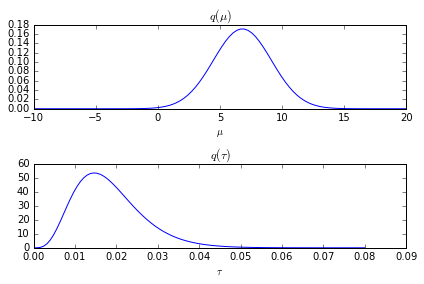

In [10]:
data = numpy.random.normal(5,10, size=(10,))
from bayespy.nodes import GaussianARD, Gamma
mu = GaussianARD(0, 1e-6)
tau = Gamma(1e-6, 1e-6)
y = GaussianARD(mu, tau, plates=(10,))

y.observe(data)

from bayespy.inference import VB
Q = VB(mu, tau, y)
Q.update(repeat=20)

bp.plot.pyplot.subplot(2,1,1)
bp.plot.pdf(mu, numpy.linspace(-10,20, num=100), name=r'\mu')
bp.plot.pyplot.subplot(2,1,2)
bp.plot.pdf(tau, numpy.linspace(1e-6,.08,num=100), name=r'\tau')
bp.plot.pyplot.tight_layout()
bp.plot.pyplot.show()
